<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Optimize_Pytorch_Lightning_models_with_Weights_&_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{pytorch-lightning-colab} -->

# About this Lecture
This Lecture + Set of Notebooks is based on many sources. Elements are pulled from the The Seventh Summer School in the MLHEP series (2021), the Hands-on Advanced Tutorial in ML at the LPC (below), the lectures fro the DSFP (below), and the documentation of the referenced ML Tools.


# Training Resources
## LHC Physics Center (LPC) [Hands-on Advanced Tutorials](https://github.com/FNALLPC/machine-learning-hats) (HATS)
The LPC at Fermi National Accelerator Lab hosts many physicists associated with the Large Hadron Collider's CMS Experiment. Amongst the many advanced tutorials offered is a series on ML, which contains recorded lectures and [repo](https://indico.cern.ch/event/1311559/). The examples include basic DNNs in both TensorFlow and Pytorch, Bayesian optimization, Convolutional Neural Networks (CNNs), Graph Neural Networks (GNNs), Variational AutoEncoders (VAEs), and Generative Adversarial Networks (GANs)

## Data Science Fellowship Program (Astro)
[DSFP](https://www.youtube.com/watch?v=FogCbMztQ_A&list=PLKC37rx5YXnddgdxLe5uB0fLRWFGlhuSK&index=1) is a program for early career researchers in the Astronomy community. The program has numerous recorded lectures and notebooks. This playlist includes an introduction to ML, and two lectures on ``Basic`` and ``Advanced`` Neural Networks which will give you another perspective on this rich field.


# Training A Simple ML Model with Pytorch Lightning


[PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/starter/introduction.html) is a thin scaffolding for abstracting away some of the boilerplate of ML training in PyTorch (It also helps with distributed training, reduced precision models, and more, but those are beyond the scope of this lecture). It does so in a way that permits us to focus on the key ingredients while retaining the flexibility and power of the Torch library.

## With Weights and Biases for Logging
Training ML models can become chaotic quickly -- much of the work can involve brute-force scanning over multiple dimensions of so-called hyper-parameters, trying many variations on model architectures, and other forms of Trial & Error. To help organize some of this chaos, we'll use a library for logging (read: tracking, checkpointing, saving) details of what we're doing. This is [Weights & Biases](https://docs.wandb.ai/quickstart)

W & B comes with [explicit integration with PyTorch Lightning](https://docs.wandb.com/library/integrations/lightning), which reduces the amount of code we'll need to add to take advantage of this tool (see below):

```python
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb_logger = WandbLogger()
trainer = Trainer(logger=wandb_logger)
```

W&B integration with Pytorch-Lightning can automatically:
* log your configuration parameters
* log your losses and metrics
* log your model
* keep track of your code
* log your system metrics (GPU, CPU, memory, temperature, etc)

### 📚 Docs
You can find the PyTorch Lightning WandbLogger docs [here](https://pytorch-lightning.readthedocs.io/en/latest/extensions/generated/pytorch_lightning.loggers.WandbLogger.html?highlight=wandblogger) and the Weights & Biases docs [here](https://docs.wandb.com/library/integrations/lightning)

### 🛠️ Installation and set-up

In [ ]:
# Uncomment this and run inside colab
#!pip install -q pytorch-lightning wandb

Weights and Biases (wandb) is a package for logging ML training and models. We'll use it's integrations with Pytorch Ligntning to keep track of configurations, parameters, models, and more. Sign into wandb.ai using the method of your choice, then follow the prompts from the wanadb.login() method to authenticate.

In [ ]:
import wandb

In [ ]:
wandb.login()

## Setting up the dataloader

We'll use the MNIST dataset, with default pytorch dataloader, and some image pre-processing hooked in from [torch transforms v2](https://pytorch.org/vision/stable/transforms.html#v1-or-v2-which-one-should-i-use)

In [ ]:
import torch
# We load the MNIST dataset (numbers) from torchvision
from torchvision.datasets import MNIST
# Some helpful tools are in ``transforms``
from torchvision.transforms import v2
# Get the DataLoader
from torch.utils.data import DataLoader, random_split

transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize((0.1307,), (0.3081,))])

dataset = MNIST(root="./MNIST", download=True, transform=transform)
training_set, validation_set = random_split(dataset, [55000, 5000])

In [ ]:
training_loader = DataLoader(training_set, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=64)

## Setting up the Model in the Scaffold

* Torch: We load the ``CrossEntropyLoss`` for this model, as we are performing a classification task
* Torch: We use ADAM as the optimizer for training the model
* W&B: Call `self.save_hyperparameters()` in `__init__` to automatically log your hyperparameters to **W&B**
* W&B: self.log needs to be called in the `training_step` and `validation_step` to save metrics
* Model: We wish to classify digits (0-9, hence 10 classes), doing so with a Feed Forward network/Multi-Layer Perceptron (MLP). We'll ingest a 28 * 28 image, and pass it through 2 hidden layers with ``n_layer_1`` and ``n_layer_2`` nodes

In [ ]:
from torch.nn import Linear, CrossEntropyLoss, functional as F
from torch.optim import Adam
from torchmetrics.functional import accuracy
from pytorch_lightning import LightningModule

class MNIST_LitModule(LightningModule):

    def __init__(self, n_classes=10, n_layer_1=128, n_layer_2=256, lr=1e-3):
        '''method used to define our model parameters'''
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = Linear(28 * 28, n_layer_1)
        self.layer_2 = Linear(n_layer_1, n_layer_2)
        self.layer_3 = Linear(n_layer_2, n_classes)

        # loss
        self.loss = CrossEntropyLoss()

        # optimizer parameters
        self.lr = lr

        # save hyper-parameters to self.hparams (auto-logged by W&B)
        self.save_hyperparameters()

    def forward(self, x):
        '''method used for inference input -> output'''

        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)

        # let's do 3 x (linear + relu)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)

        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)

        return loss

    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        # Let's return preds to use it in a custom callback
        return preds

    def test_step(self, batch, batch_idx):
        '''used for logging metrics'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)

    def configure_optimizers(self):
        '''defines model optimizer'''
        return Adam(self.parameters(), lr=self.lr)

    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, y)
        acc = accuracy(preds, y, 'multiclass', num_classes=10)
        return preds, loss, acc

Lets instantiate a model from this class

In [ ]:
model = MNIST_LitModule(n_layer_1=128, n_layer_2=128)

## Model Checkpoints

We'd like to keep track of not only configuration parameters and accuracy or loss, but checkpoints of the model itself

The `ModelCheckpoint` callback is required along with the `WandbLogger` argument to log model checkpoints to W&B.

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')

##  Tracking Experiments with WandbLogger

PyTorch Lightning has a `WandbLogger` to easily log your experiments with Wights & Biases. Just pass it to your `Trainer` to log to W&B. See the [WandbLogger docs](https://pytorch-lightning.readthedocs.io/en/stable/extensions/generated/pytorch_lightning.loggers.WandbLogger.html#pytorch_lightning.loggers.WandbLogger) for all parameters. Note, to log the metrics to a specific W&B Team, pass your Team name to the `entity` argument in `WandbLogger`

#### `pytorch_lightning.loggers.WandbLogger()`

| Functionality | Argument/Function | PS |
| ------ | ------ | ------ |
| Logging models | `WandbLogger(... ,log_model='all')` or `WandbLogger(... ,log_model=True`) | Log all models if `log_model="all"` and at end of training if `log_model=True`
| Set custom run names | `WandbLogger(... ,name='my_run_name'`) | |
| Organize runs by project | `WandbLogger(... ,project='my_project')` | |
| Log histograms of gradients and parameters | `WandbLogger.watch(model)`  | `WandbLogger.watch(model, log='all')` to log parameter histograms  |
| Log hyperparameters | Call `self.save_hyperparameters()` within `LightningModule.__init__()` |
| Log custom objects (images, audio, video, molecules…) | Use `WandbLogger.log_text`, `WandbLogger.log_image` and `WandbLogger.log_table` |

See the [WandbLogger docs](https://pytorch-lightning.readthedocs.io/en/stable/extensions/generated/pytorch_lightning.loggers.WandbLogger.html#pytorch_lightning.loggers.WandbLogger) here for all parameters.

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

# The project name just groups the upcoming model logs for us to identify and analyze later
wandb_logger = WandbLogger(project='MNIST', # group runs in "MNIST" project
                           #group='A', # does what it says, group models together for tracking
                           name='MLP1', # helpful name for this particular model version
                           log_model='all') # log all new checkpoints during training

## Using WandbLogger to log Images, Text and More
Pytorch Lightning is extensible through its callback system. We can create a custom callback to automatically log sample predictions during validation. `WandbLogger` provides convenient media logging functions:
* `WandbLogger.log_text` for text data
* `WandbLogger.log_image` for images
* `WandbLogger.log_table` for [W&B Tables](https://docs.wandb.ai/guides/data-vis).

An alternate to `self.log` in the Model class is directly using `wandb.log({dict})` or `trainer.logger.experiment.log({dict})`

In this case we log the first 20 images in the first batch of the validation dataset along with the predicted and ground truth labels.

In [ ]:
from pytorch_lightning.callbacks import Callback

class LogPredictionsCallback(Callback):
    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx):
        """Called when the validation batch ends."""

        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case

        # Let's log 20 sample image predictions from first batch
        if batch_idx == 0:
            n = 20
            x, y = batch
            images = [img for img in x[:n]]
            captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' for y_i, y_pred in zip(y[:n], outputs[:n])]

            # Option 1: log images with `WandbLogger.log_image`
            trainer.logger.log_image(key='sample_images', images=images, caption=captions)

            # Option 2: log predictions as a Table
            columns = ['image', 'ground truth', 'prediction']
            data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
            trainer.logger.log_table(key='sample_table', columns=columns, data=data)

log_predictions_callback = LogPredictionsCallback()

## Train The Model

We'll set up a trainer, specifying wandb_logger insantiated above as the logger, specify the log_predictions_callback and checkpoint_callback functions, and choose the accelerator + max_epochs to train over.
One additional detail, we want to register the model itself with the logger, so that it can keep track of gradients and weights

In [ ]:
trainer = Trainer(
    logger=wandb_logger,                    # W&B integration
    callbacks=[log_predictions_callback,    # logging of sample predictions
               checkpoint_callback],        # our model checkpoint callback
    accelerator="cpu",                      # use cpu or gpu
    max_epochs=5)                           # number of epochs
trainer.logger.watch(model, log="all")      # tell the W&B logger to watch the model, going through the trainer interface to keep things clean

When we want to close our W&B run, we want to call `wandb.finish()` (mainly useful in notebooks, docs note that it's called automatically in scripts). We'll want to do this for each time we instantiate a new logger/trainer combo and send a model through the fitting process, so that it finalizes all the stats and uploads any relevant details to the server.

In [ ]:
trainer.fit(model, training_loader, validation_loader)
wandb_logger.experiment.unwatch(model)
wandb.finish()

# Training a Few More Models

In [ ]:
# Lets define another models with a different numbers of layer nodes
# We need a new instantiation of the trainer, including a new logger instance, but we'll keep the same callbacks
model2 = MNIST_LitModule(n_layer_1=256, n_layer_2=256)
trainer2 = Trainer(
    logger=WandbLogger(project='MNIST', # group runs in "MNIST" project
                       #group='A', # does what it says, group models together for tracking
                       name='MLP2', # helpful name for this particular model version
                       log_model='all'), # log all new checkpoints during training,
    callbacks=[log_predictions_callback,
               checkpoint_callback],
    accelerator="cpu",
    max_epochs=10)
trainer2.logger.watch(model2)

In [ ]:
trainer2.fit(model2, training_loader, validation_loader)
trainer2.logger.experiment.unwatch(model2)

In [ ]:
wandb.finish()

In [ ]:
# Just one more model...
model3 = MNIST_LitModule(n_layer_1=128, n_layer_2=64)
trainer3 = Trainer(
    logger=WandbLogger(project='MNIST', # group runs in "MNIST" project
                       #group='A', # does what it says, group models together for tracking
                       name='MLP3', # helpful name for this particular model version
                       log_model='all'), # log all new checkpoints during training,
    callbacks=[log_predictions_callback,
               checkpoint_callback],
    accelerator="cpu",
    max_epochs=10)
trainer3.logger.watch(model3)

In [ ]:
trainer3.fit(model3, training_loader, validation_loader)
trainer3.logger.experiment.unwatch(model3)

In [ ]:
wandb.finish()

We can monitor losses, metrics, gradients, parameters and sample predictions as the model trains.

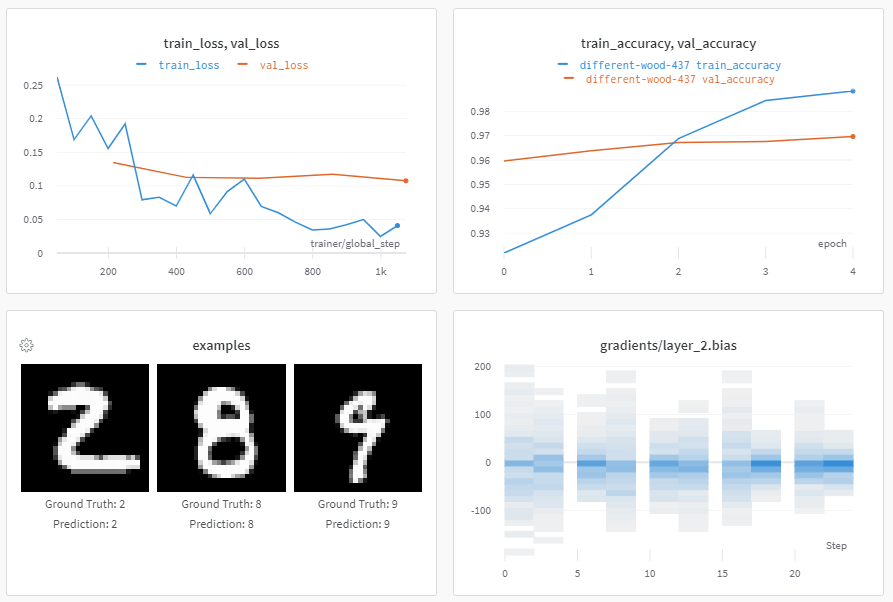